## Dependencies

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.feature_selection import VarianceThreshold
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer, root_mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

RANDOM_SEED=42

## Exploratory Data Analysis

Store our data in DataFrame format for easy analysis

In [23]:
df = pd.read_csv("dataset_new.csv")
df.head(10)

,X,Y,base_station_user,sector_of_BS_user,sector_user,ModulationType,Power_W_,BS_UEDistance_km_,BS_UEAngle_degrees_,Throughput_Mbps_
0,-1538.494704,1229.952836,10,1,28,QPSK,0.176421,2.175760,195.063406,379.315339
1,-1392.160776,1583.572523,9,1,25,16-QAM,0.053331,1.968813,326.605415,299.266046
2,34.900399,-1440.542036,1,1,1,QPSK,0.000312,0.049357,347.032825,1161.318447
3,-1482.404758,1613.021019,9,1,25,16-QAM,0.125557,2.096437,152.344674,814.071594
4,1451.921185,521.828373,12,2,35,64-QAM,0.017777,2.053327,314.814695,1192.715985
5,616.326717,-1554.882990,7,1,19,64-QAM,0.013619,0.871618,192.214154,628.549844
6,159.214320,-852.220482,1,3,3,16-QAM,0.005459,0.225163,215.237927,241.695996
7,-981.174170,189.916792,14,2,41,64-QAM,0.219217,1.387590,263.987159,1492.662793
8,1034.613979,1784.382421,17,3,51,QPSK,0.215195,1.463165,284.441736,176.481929
9,-1046.819888,1813.045696,16,2,47,16-QAM,0.173601,1.480427,0.643953,317.376338


Our dataset is complete, without any missing observations.

We have 10075 entries, 9 features and 1 target variable.

Our target variable *Throughput_Mbps_* is continuous of type float.

We also have 8 numerical features (5 float64 and 1 int64) and 1 string feature.

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10075 entries, 0 to 10074
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   X                    10075 non-null  float64
 1   Y                    10075 non-null  float64
 2   base_station_user    10075 non-null  int64  
 3   sector_of_BS_user    10075 non-null  int64  
 4   sector_user          10075 non-null  int64  
 5   ModulationType       10075 non-null  object 
 6   Power_W_             10075 non-null  float64
 7   BS_UEDistance_km_    10075 non-null  float64
 8   BS_UEAngle_degrees_  10075 non-null  float64
 9   Throughput_Mbps_     10075 non-null  float64
dtypes: float64(6), int64(3), object(1)
memory usage: 787.2+ KB


We have a categorical variable *ModulationType* that we must encode.

In [32]:
df['ModulationType'].unique()

array(['QPSK', '16-QAM', '64-QAM'], dtype=object)

We will use a Label Encoder instead of One-Hot Encoding.

In [33]:
df['ModulationType_encoded'] = LabelEncoder().fit_transform(df['ModulationType'])
df['ModulationType_encoded'].unique()

array([2, 0, 1])

Let's view some important statistics for out variables

In [34]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
X,10075.0,-0.873547,973.217106,-1933.634171,-767.617498,-4.333914,769.758855,1949.384158
Y,10075.0,5.123516,1118.105485,-1933.361347,-964.260796,21.238259,970.154609,1948.578682
base_station_user,10075.0,9.940149,5.546981,1.000000,5.000000,10.000000,15.000000,19.000000
sector_of_BS_user,10075.0,1.998710,0.815340,1.000000,1.000000,2.000000,3.000000,3.000000
sector_user,10075.0,28.819156,16.675274,1.000000,14.000000,29.000000,43.000000,57.000000
Power_W_,10075.0,0.087622,0.078282,0.000001,0.016646,0.066481,0.147044,0.308286
BS_UEDistance_km_,10075.0,1.147903,0.759271,0.000332,0.440289,1.087166,1.917052,2.756846
BS_UEAngle_degrees_,10075.0,178.527259,104.167410,0.162053,88.379195,178.146271,268.662899,359.991669
Throughput_Mbps_,10075.0,813.887653,399.745375,117.021646,473.088025,811.654472,1160.667322,1499.884142
ModulationType_encoded,10075.0,0.966154,0.809013,0.000000,0.000000,1.000000,2.000000,2.000000


Now let us visualize the distributions of our features.

*X* has a kind of normal distribution and all other features except *Power_W_* have very uniform distributions.

*Power_W_* has a distinct right skew, which could be improved by transforming the feature. We will look into this.

Our target *Throughput_Mbps_* has a very uniform distribution as well.

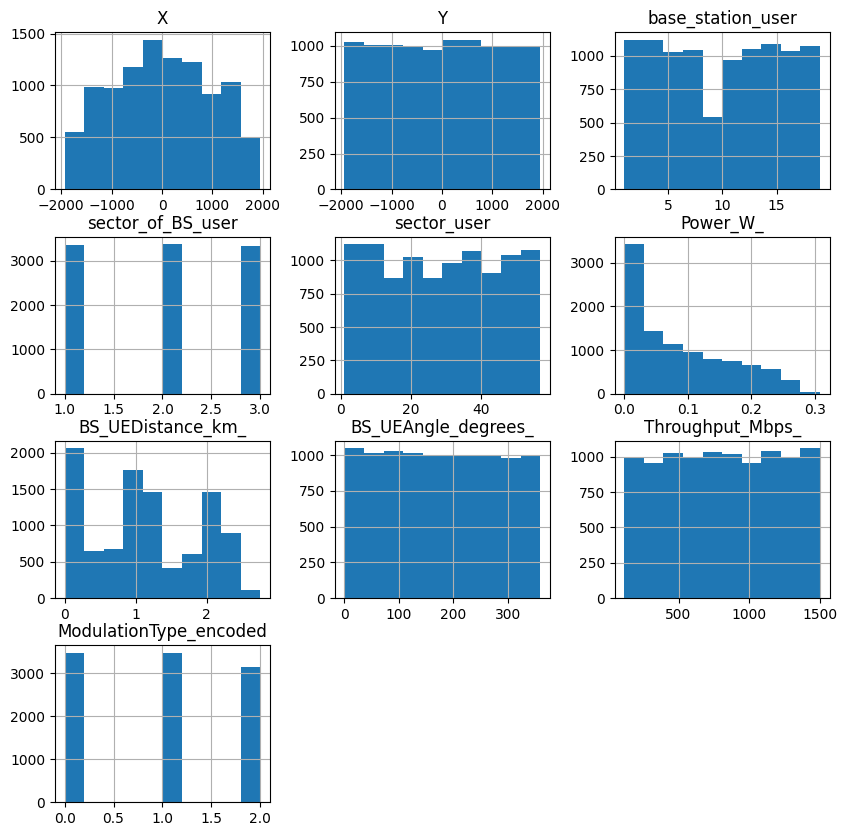

In [35]:
_ = df.hist(figsize=(10, 10))

We will investigate linear dependencies between our independent variables.

We observe that *sector_user* and *base_station_user* have a perfect spearman correlation of 1.

We must address this.

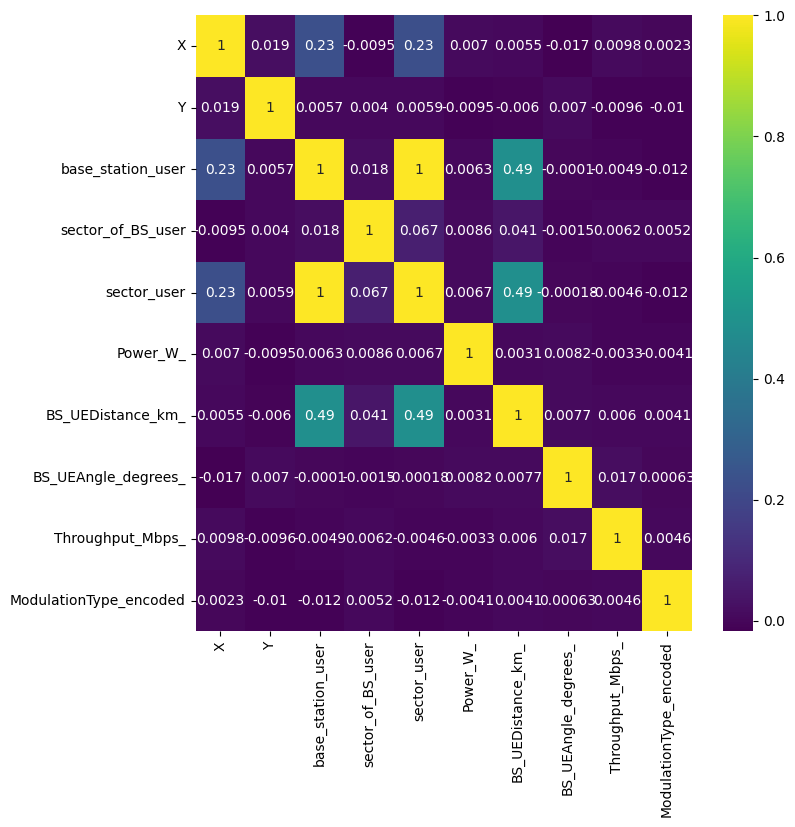

In [36]:
corr_matrix = df.select_dtypes(include=['number']).corr()
plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=True, cmap='viridis')
_ = plt.show()

Let us visualize the relationship with a scatterplot.

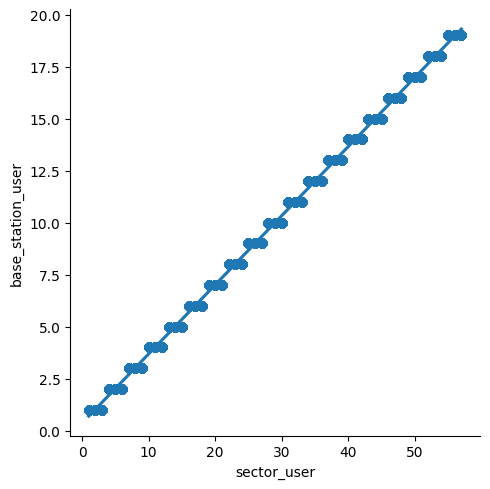

In [37]:
_ = sns.lmplot(x='sector_user', y='base_station_user', data=df)

To decide on which feature to retain and which to discard from the correlated pair *sector_user* and *base_station_user* we will fit a RandomForest model and see what feature importance does it assign to each feature.

We see that *sector_user* is more than twice as important as *base_station_user*, which hints us that we might have to remove *base_station_user*.

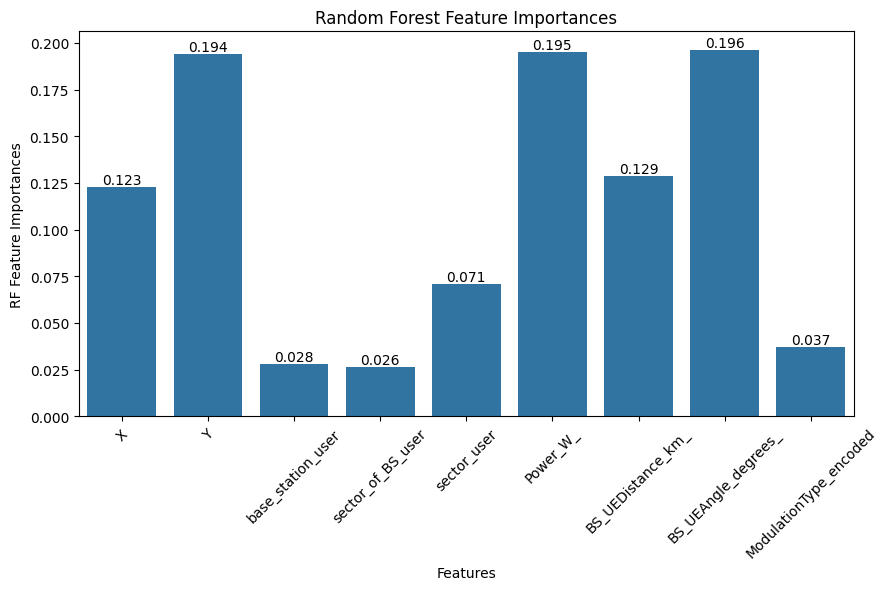

In [38]:
model = RandomForestRegressor()

model.fit(df.drop(columns=['Throughput_Mbps_', "ModulationType"]), y=df['Throughput_Mbps_'])

fig = plt.figure(figsize=(10, 5))

ax = sns.barplot(
    x=df.drop(columns=['Throughput_Mbps_', "ModulationType"]).columns, 
    y=model.feature_importances_
)

for bar, importance in zip(ax.patches, model.feature_importances_):
    ax.annotate(
        f'{importance:.3f}',
        (bar.get_x() + bar.get_width() / 2, bar.get_height()),
        ha='center', va='bottom', fontsize=10, color='black'
    )

plt.xlabel("Features")
plt.ylabel("RF Feature Importances")
plt.title("Random Forest Feature Importances")

plt.xticks(rotation=45)
plt.show()



Another feature selection technique for correlated features is using variance as a metric and choose features with high variance.

We again observe that *sector_user* has almost 3 times as much variance as *base_station_user*

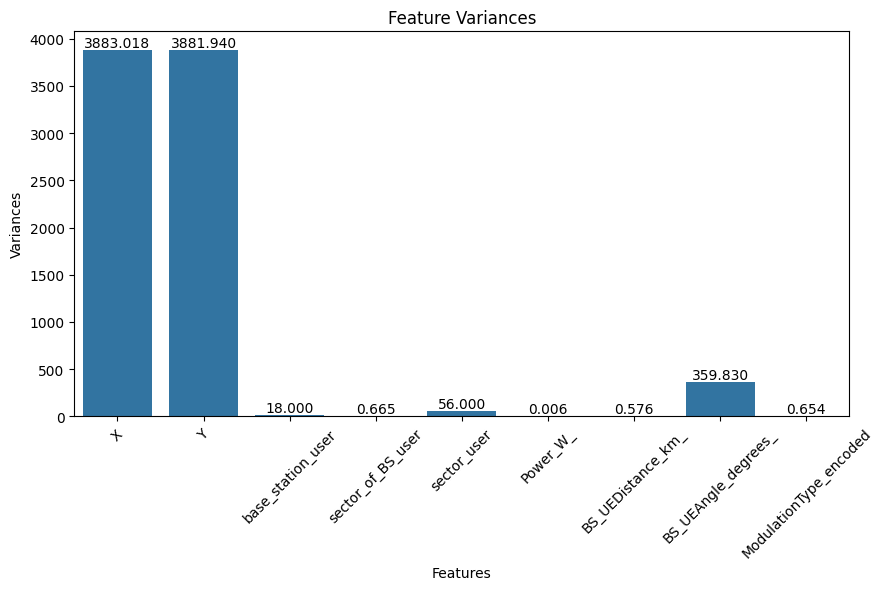

In [39]:
selector = VarianceThreshold()

variance = selector.fit_transform(df.drop(columns=['Throughput_Mbps_', "ModulationType"]))

variances = selector.variances_

fig = plt.figure(figsize=(10, 5))

ax = sns.barplot(
    x=df.drop(columns=['Throughput_Mbps_', "ModulationType"]).columns, 
    y=selector.variances_
)

for bar, importance in zip(ax.patches, selector.variances_):
    ax.annotate(
        f'{importance:.3f}',
        (bar.get_x() + bar.get_width() / 2, bar.get_height()),
        ha='center', va='bottom', fontsize=10, color='black'
    )

plt.xlabel("Features")
plt.ylabel("Variances")
plt.title("Feature Variances")

plt.xticks(rotation=45)
plt.show()


Therefore we decided on retaining *sector_user* and on dropping *base_station_user*.

We see that there are no highly correlated features in our data now.

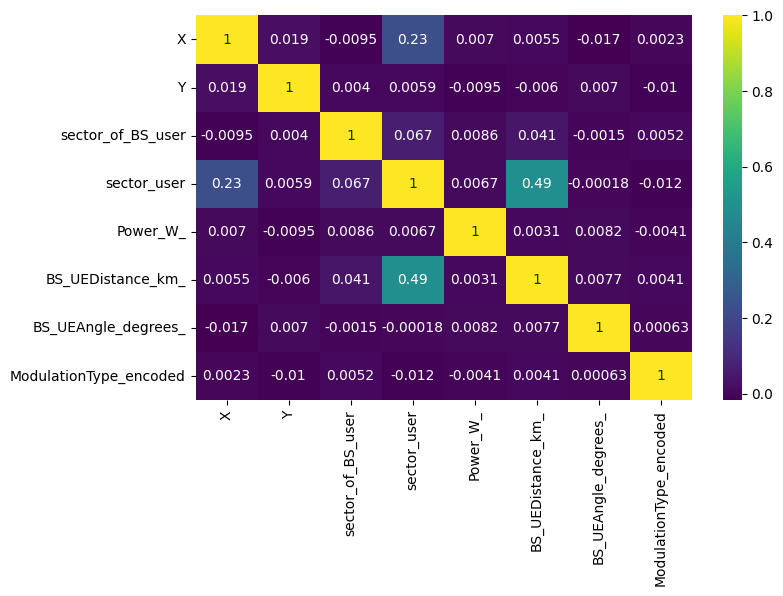

In [40]:
df = df.drop(columns=['ModulationType', 'base_station_user'])
plt.figure(figsize=(8, 5))
_ = sns.heatmap(df.drop(columns=["Throughput_Mbps_"]).corr(), annot=True, cmap="viridis")

## Feature Engineering

We said that we will try to fix the skewed distribution of *Power_W_*.

We will use a square root transformation.

As we can see the distribution is much more uniform now.

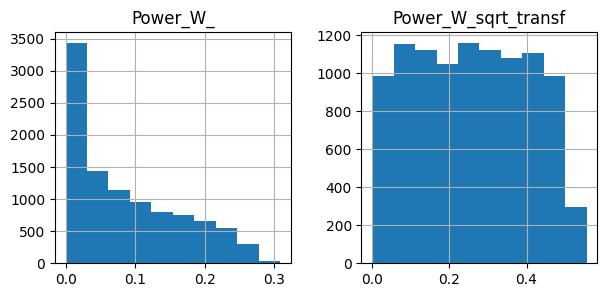

In [42]:
df["Power_W_sqrt_transf"] = np.sqrt(df["Power_W_"])

_ = df[["Power_W_", "Power_W_sqrt_transf"]].hist(figsize=(7, 3))

Regarding *BS_UEAngle_degrees_*. We know that angles are cyclic, meaning 0 and 360 represent the same point in a circle. However, the raw angle values are numerically far apart.

We can use the sine and cosine to the angle to points on a unit circle, where equivalent angles have the same representation, thus preserving the geometric relationship between angles while making it easier for our models to understand the relationship between them.

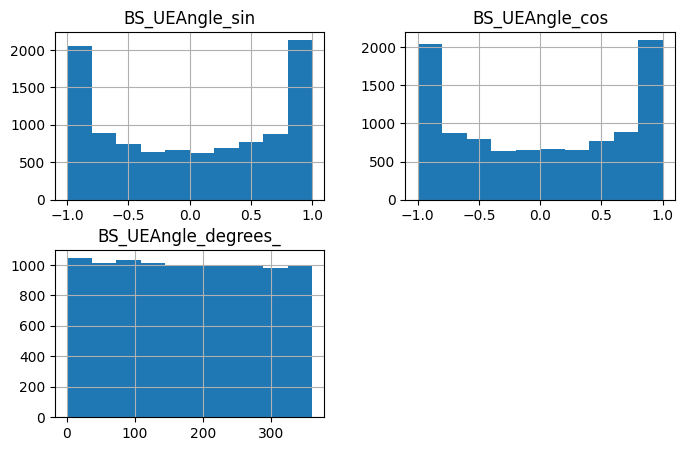

In [45]:
df['BS_UEAngle_sin'] = np.sin(np.radians(df['BS_UEAngle_degrees_']))
df['BS_UEAngle_cos'] = np.cos(np.radians(df['BS_UEAngle_degrees_']))
_ = df[["BS_UEAngle_sin", "BS_UEAngle_cos", "BS_UEAngle_degrees_"]].hist(figsize=(8, 5))

Split features from target

In [48]:
X = df.drop(columns='Throughput_Mbps_')
y = df['Throughput_Mbps_']

## Regression

In [49]:
X.columns

Index(['X', 'Y', 'sector_of_BS_user', 'sector_user', 'Power_W_',
       'BS_UEDistance_km_', 'BS_UEAngle_degrees_', 'ModulationType_encoded',
       'Power_W_sqrt_transf', 'BS_UEAngle_sin', 'BS_UEAngle_cos'],
      dtype='object')

Keep the needed features, while excluding *Power_W_*, *BS_UEAngle_degrees_* which we transformed.

In [50]:
X_MLP = X[['X', 'Y', 'sector_of_BS_user', 'sector_user', 'BS_UEDistance_km_', 'ModulationType_encoded',
       'Power_W_sqrt_transf', 'BS_UEAngle_sin', 'BS_UEAngle_cos']]

Split our data into training and validation sets with a 80/20 ratio.

In [51]:
X_MLP_train, X_MLP_val, y_mlp_train, y_mlp_val = train_test_split(X_MLP, y, random_state=RANDOM_SEED, test_size=0.2)

Instead of trying to predict the raw throughput, we will scale it to a range [0, 1].

During deployment the same scaler can be used to transform our predictions to the corresponding raw throughput values.

Additionally, will scale all features to a range of [-1, 1]. MLPs are sensitive to different feature scales, thus scaling will help make features more comparable to one another. The reason why we scale to [-1, 1] and not [0, 1] is the fact that the features *BS_UEAngle_sin* and *BS_UEAngle_cos* are already in that range and scaling them to [0, 1] would distort the information that these features provide.

In [59]:
target_scaler = MinMaxScaler(feature_range=(0, 1))
feature_scaler = MinMaxScaler(feature_range=(-1, 1))

X_MLP_train = feature_scaler.fit_transform(X_MLP_train)
y_mlp_train = target_scaler.fit_transform(y_mlp_train.to_numpy().reshape(-1, 1))
X_MLP_val = feature_scaler.transform(X_MLP_val)
y_mlp_val = target_scaler.transform(y_mlp_val.to_numpy().reshape(-1, 1))

For the MLP, we must use a tanh activation function and not ReLU since we have scaled our features in the range [-1, 1]. 

We will use early stopping to avoid overfitting and we will carry out a 5-fold cross validation based on MSE to search for:
1. Optimal number of neurons per layer
2. Best optimizer
3. Learning rate and schedule. 

In [99]:
regressors_parametered = [
    ("MLPRegressor", MLPRegressor(random_state=RANDOM_SEED, 
                                  max_iter=1000,
                                  early_stopping=True,
                                  activation="tanh",),
    {"classifier__hidden_layer_sizes": [[128, 128, 128, 128, 128], [256, 256, 256, 256, 256], [512, 512, 512, 512, 512]],
     "classifier__solver": ['sgd', 'adam'],
     "classifier__learning_rate": ['invscaling', 'adaptive'],
     "classifier__learning_rate_init": [0.001, 0.01]})
]

In [100]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
scorer = make_scorer(mean_squared_error)

In [101]:
best_params, best_models = {}, {}

for name, regressor, param_grid in regressors_parametered:
    pipeline = Pipeline([('classifier', regressor)])
    grid_search = GridSearchCV(pipeline, param_grid, scoring=scorer, n_jobs=4)
    grid_search.fit(X_MLP_train, y_mlp_train.ravel())
    best_models[name] = grid_search.best_estimator_
    best_params[name] = grid_search.best_params_
    print(f"Best Parameters for {name}: {best_params[name]}")

Best Parameters for MLPRegressor: {'classifier__hidden_layer_sizes': [512, 512, 512, 512, 512], 'classifier__learning_rate': 'invscaling', 'classifier__learning_rate_init': 0.001, 'classifier__solver': 'sgd'}


Our model performs very well on the validation set with a minimal MSE.

In [59]:
y_pred_mlp = best_models['MLPRegressor'].predict(X_MLP_val)
mse_mlp = mean_squared_error(y_mlp_val, y_pred_mlp)
mae_mlp = mean_absolute_error(y_mlp_val, y_pred_mlp)
rmse_mlp = root_mean_squared_error(y_mlp_val, y_pred_mlp)

print("MLP Model Performance:")
print(f"\tMSE: {mse_mlp}\n\tMAE: {mae_mlp}\n\tRMSE: {rmse_mlp}")

MLP Model Performance:
	MSE: 0.08595819555202318
	MAE: 0.25295906572538085
	RMSE: 0.29318628131620206


In [107]:
num_bins = 4
y_equal_width = pd.cut(y, bins=num_bins, labels=False)
y_equal_frequency = pd.qcut(y, q=num_bins, labels=False)


In [62]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report


X_train, X_test, y_train, y_test = train_test_split(X, y_equal_frequency, test_size=0.2, random_state=42)
# Train a Decision Tree
decision_tree = DecisionTreeClassifier(max_depth=5, random_state=42)  # Max depth of 5 for simplicity
decision_tree.fit(X_train, y_train)

# Predictions
y_pred_tree = decision_tree.predict(X_test)

# Accuracy
print(classification_report(y_test, y_pred_tree))

              precision    recall  f1-score   support

           0       0.33      0.46      0.38       662
           1       0.32      0.24      0.27       686
           2       0.32      0.27      0.29       667

    accuracy                           0.32      2015
   macro avg       0.32      0.32      0.32      2015
weighted avg       0.32      0.32      0.32      2015



In [78]:
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["Throughput_Mbps_"]), y_equal_width, test_size=0.2, random_state=42)
# Train a Decision Tree
decision_tree = SVC(random_state=42)  # Max depth of 5 for simplicity
decision_tree.fit(X_train, y_train)

# Predictions
y_pred_svc = decision_tree.predict(X_test)

# Accuracy
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.48      0.47      0.48       990
           1       0.50      0.51      0.50      1025

    accuracy                           0.49      2015
   macro avg       0.49      0.49      0.49      2015
weighted avg       0.49      0.49      0.49      2015



In [84]:
X_train, X_test, y_train, y_test = train_test_split(X[['X', 'Y', 'sector_of_BS_user', 'sector_user', 'BS_UEDistance_km_', 'ModulationType_encoded',
       'Power_W_sqrt_transf', 'BS_UEAngle_sin', 'BS_UEAngle_cos']], y_equal_width, test_size=0.2, random_state=42)
# Train a Decision Tree
decision_tree = SVC(random_state=42)  # Max depth of 5 for simplicity
decision_tree.fit(X_train, y_train)

# Predictions
y_pred_svc = decision_tree.predict(X_test)

# Accuracy
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.48      0.47      0.48       990
           1       0.50      0.51      0.51      1025

    accuracy                           0.49      2015
   macro avg       0.49      0.49      0.49      2015
weighted avg       0.49      0.49      0.49      2015



In [85]:
X_train, X_test, y_train, y_test = train_test_split(X[['X', 'Y', 'sector_of_BS_user', 'sector_user', 'BS_UEDistance_km_', 'ModulationType_encoded',
       'Power_W_sqrt_transf', 'BS_UEAngle_sin', 'BS_UEAngle_cos']], y_equal_width, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# Train a Decision Tree
decision_tree = SVC(kernel="rbf", degree=15, random_state=42)  # Max depth of 5 for simplicity
decision_tree.fit(X_train, y_train)

# Predictions
y_pred_svc = decision_tree.predict(X_test)

# Accuracy
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.50      0.49      0.50       990
           1       0.52      0.52      0.52      1025

    accuracy                           0.51      2015
   macro avg       0.51      0.51      0.51      2015
weighted avg       0.51      0.51      0.51      2015



In [120]:
X1 = X[['X', 'Y', 'sector_of_BS_user', 'sector_user', 'BS_UEDistance_km_', 'ModulationType_encoded',
       'Power_W_sqrt_transf', 'BS_UEAngle_sin', 'BS_UEAngle_cos']]

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X1, y_equal_width, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# Train a Decision Tree
decision_tree = SVC(kernel="rbf", degree=15, random_state=42)  # Max depth of 5 for simplicity
decision_tree.fit(X_train, y_train)

# Predictions
y_pred_svc = decision_tree.predict(X_test)

# Accuracy
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.24      0.21      0.22       483
           1       0.26      0.31      0.28       507
           2       0.26      0.24      0.25       507
           3       0.27      0.26      0.27       518

    accuracy                           0.26      2015
   macro avg       0.26      0.26      0.26      2015
weighted avg       0.26      0.26      0.26      2015



In [125]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_interactions = poly.fit_transform(X1)
X_combined = np.hstack((X1, X_interactions))
X1.shape, X_interactions.shape, X_combined.shape

((10075, 9), (10075, 45), (10075, 54))

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_equal_frequency, test_size=0.2, random_state=42)

# Train a Decision Tree
decision_tree = RandomForestClassifier(random_state=42)  # Max depth of 5 for simplicity
decision_tree.fit(X_train, y_train)

# Predictions
y_pred_svc = decision_tree.predict(X_test)

# Accuracy
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.25      0.27      0.26       494
           1       0.23      0.25      0.24       501
           2       0.24      0.22      0.23       507
           3       0.23      0.21      0.22       513

    accuracy                           0.24      2015
   macro avg       0.24      0.24      0.24      2015
weighted avg       0.24      0.24      0.24      2015



In [119]:
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_equal_width, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# Train a Decision Tree
decision_tree = SVC(kernel="rbf", degree=2, random_state=42)  # Max depth of 5 for simplicity
decision_tree.fit(X_train, y_train)

# Predictions
y_pred_svc = decision_tree.predict(X_test)

# Accuracy
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.24      0.24      0.24       483
           1       0.26      0.29      0.28       507
           2       0.26      0.25      0.25       507
           3       0.25      0.23      0.24       518

    accuracy                           0.25      2015
   macro avg       0.25      0.25      0.25      2015
weighted avg       0.25      0.25      0.25      2015



In [116]:
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["Throughput_Mbps_"]), y_equal_width, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# Train a Decision Tree
decision_tree = LogisticRegression(random_state=42)  # Max depth of 5 for simplicity
decision_tree.fit(X_train, y_train)

# Predictions
y_pred_svc = decision_tree.predict(X_test)

# Accuracy
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.21      0.15      0.17       483
           1       0.26      0.31      0.28       507
           2       0.24      0.24      0.24       507
           3       0.27      0.28      0.27       518

    accuracy                           0.25      2015
   macro avg       0.24      0.25      0.24      2015
weighted avg       0.24      0.25      0.24      2015



In [12]:
df.columns

Index(['X', 'Y', 'sector_of_BS_user', 'sector_user', 'Power_W_',
       'BS_UEDistance_km_', 'BS_UEAngle_degrees_', 'Throughput_Mbps_',
       'ModulationType_encoded'],
      dtype='object')

In [18]:
num_bins = 4
df["Throughput_Mbps_Encoded"] = pd.qcut(df["Throughput_Mbps_"], q=num_bins, labels=False)
df.drop(columns=["Throughput_Mbps_"], inplace=True)
df.columns

Index(['X', 'Y', 'sector_of_BS_user', 'sector_user', 'Power_W_',
       'BS_UEDistance_km_', 'BS_UEAngle_degrees_', 'ModulationType_encoded',
       'Throughput_Mbps_Encoded'],
      dtype='object')

array([[<Axes: title={'center': 'X'}>, <Axes: title={'center': 'Y'}>,
        <Axes: title={'center': 'sector_of_BS_user'}>],
       [<Axes: title={'center': 'sector_user'}>,
        <Axes: title={'center': 'Power_W_'}>,
        <Axes: title={'center': 'BS_UEDistance_km_'}>],
       [<Axes: title={'center': 'BS_UEAngle_degrees_'}>,
        <Axes: title={'center': 'ModulationType_encoded'}>,
        <Axes: title={'center': 'Throughput_Mbps_Encoded'}>]],
      dtype=object)

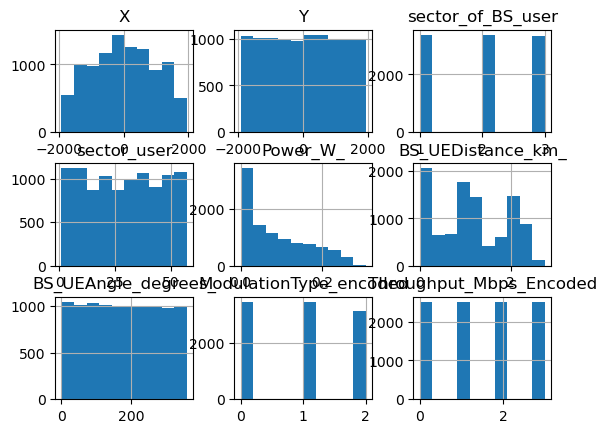

In [21]:
df.hist()

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["Throughput_Mbps_Encoded"]), df["Throughput_Mbps_Encoded"], test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# Train a Decision Tree
decision_tree = LogisticRegression(random_state=42)  # Max depth of 5 for simplicity
decision_tree.fit(X_train, y_train)

# Predictions
y_pred_svc = decision_tree.predict(X_test)

# Accuracy
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.23      0.26      0.24       494
           1       0.26      0.25      0.25       501
           2       0.23      0.27      0.25       507
           3       0.24      0.19      0.21       513

    accuracy                           0.24      2015
   macro avg       0.24      0.24      0.24      2015
weighted avg       0.24      0.24      0.24      2015

